In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Tools

In [3]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

results = list(powerset([1, 2, 3]))
print(results)

[(), (1,), (2,), (3,), (1, 2), (1, 3), (2, 3), (1, 2, 3)]


In [4]:
calc_size = lambda x: x * (2**x)

for i in range(10, 100, 10):
    print(i, calc_size(i))

10 10240
20 20971520
30 32212254720
40 43980465111040
50 56294995342131200
60 69175290276410818560
70 82641413450218791239680
80 96714065569170333976494080
90 111414603535684224740921180160


## Gen Data

In [5]:
def gen_full_dataset(num_attributes, num_attr_vals, num_cards_per_query, nest_depth_int):
    
    K = num_attr_vals
    queries = list(powerset([i for i in range(K)]))
    num_queries = len(queries)
    datapoints = []
    tokens = []
    lens = []
    count_table = np.zeros((K+1, num_queries)) # null card +1

    for q_i, q in enumerate(queries):
        
        if not q: # null card for empty set
            lens.append(1)
            datapoints.append((q_i, K))
            tokens.append(((K,), K))
            count_table[K, q_i] += 1 
        else:
            lens.append(len(q))
            for k in q:
                datapoints.append((q_i, k))
                tokens.append((q, k))
                count_table[k, q_i] += 1 
    
    base_vocab_size = K+1
    
    data = {
        'num_attributes': 1,
        'num_attr_vals': K,
        'num_cards_per_query': K,
        'nest_depth_int': 1,
        'key_support_size': K+1,
        'query_support_size': num_queries,
        'max_len_q': K,
        'len_k': 1,
        'hold_out': False,
        'train_datapoints': datapoints,
        'val_datapoints': None,
        'train_tokens': tokens,
        'val_tokens': None,
        'sparsity_estimate': sum(lens) / ((K+1) * num_queries),
        'vocab_size': base_vocab_size + 7,
        '(': base_vocab_size,
        ')': base_vocab_size + 1,
        'NULL': base_vocab_size + 2,
        'SEP': base_vocab_size + 3,
        'SOS': base_vocab_size + 4,
        'EOS': base_vocab_size + 5,
        'PAD': base_vocab_size + 6,
    }
    
    return data

In [6]:
def construct_full_matrix(num_attributes, num_attr_vals, num_cards_per_query, nest_depth_int):
    K = num_attr_vals
    queries = list(powerset([i for i in range(K)]))
    num_queries = len(queries)
    count_table = np.zeros((K+1, num_queries)) # with null card

    for q_i, q in enumerate(queries):
        if not q: # null card for empty set
            count_table[K, q_i] += 1 
        for k in q:
            count_table[k, q_i] += 1 
            
    return count_table

def report_countable_distribution(count_table):
    num_keys = count_table.shape[0]
    num_queries = count_table.shape[1]
    xy = count_table/np.sum(count_table)
    xy /= np.sum(xy)
    x = np.sum(xy,0)
    y = np.sum(xy,1)
    xyind = y[None].T @ x[None]
    xy_div_xyind = xy / xyind
    sparsity = np.sum(count_table) / (xy.shape[0] * xy.shape[1])
    tot_size = num_keys * num_queries
    distribution = {
        'num_keys': num_keys,
        'num_queries': num_queries,
        'tot_size': tot_size,
        'shape': xy.shape,
        'sparsity': sparsity,
        'xy_rank': num_keys, # SET is full rank
        'xy_div_xyind_rank': num_keys # SET is full rank
    } 
    return count_table, xy, xyind, xy_div_xyind, distribution

def gen_full_matrices(num_attributes, num_attr_vals, num_cards_per_query, nest_depth_int):
    count_table = construct_full_matrix(num_attributes, num_attr_vals, num_cards_per_query, nest_depth_int)
    return report_countable_distribution(count_table)

In [7]:
count_table, xy, xyind, xy_div_xyind, distribution = gen_full_matrices(1,10,1,1)
distribution

{'num_keys': 11,
 'num_queries': 1024,
 'tot_size': 11264,
 'shape': (11, 1024),
 'sparsity': 0.45463423295454547,
 'xy_rank': 11,
 'xy_div_xyind_rank': 11}

In [8]:
data = gen_full_dataset(1,10,1,1)
data

{'num_attributes': 1,
 'num_attr_vals': 10,
 'num_cards_per_query': 10,
 'nest_depth_int': 1,
 'key_support_size': 11,
 'query_support_size': 1024,
 'max_len_q': 10,
 'len_k': 1,
 'hold_out': False,
 'train_datapoints': [(0, 10),
  (1, 0),
  (2, 1),
  (3, 2),
  (4, 3),
  (5, 4),
  (6, 5),
  (7, 6),
  (8, 7),
  (9, 8),
  (10, 9),
  (11, 0),
  (11, 1),
  (12, 0),
  (12, 2),
  (13, 0),
  (13, 3),
  (14, 0),
  (14, 4),
  (15, 0),
  (15, 5),
  (16, 0),
  (16, 6),
  (17, 0),
  (17, 7),
  (18, 0),
  (18, 8),
  (19, 0),
  (19, 9),
  (20, 1),
  (20, 2),
  (21, 1),
  (21, 3),
  (22, 1),
  (22, 4),
  (23, 1),
  (23, 5),
  (24, 1),
  (24, 6),
  (25, 1),
  (25, 7),
  (26, 1),
  (26, 8),
  (27, 1),
  (27, 9),
  (28, 2),
  (28, 3),
  (29, 2),
  (29, 4),
  (30, 2),
  (30, 5),
  (31, 2),
  (31, 6),
  (32, 2),
  (32, 7),
  (33, 2),
  (33, 8),
  (34, 2),
  (34, 9),
  (35, 3),
  (35, 4),
  (36, 3),
  (36, 5),
  (37, 3),
  (37, 6),
  (38, 3),
  (38, 7),
  (39, 3),
  (39, 8),
  (40, 3),
  (40, 9),
  (41, 4)

In [9]:
data['train_tokens']

[((10,), 10),
 ((0,), 0),
 ((1,), 1),
 ((2,), 2),
 ((3,), 3),
 ((4,), 4),
 ((5,), 5),
 ((6,), 6),
 ((7,), 7),
 ((8,), 8),
 ((9,), 9),
 ((0, 1), 0),
 ((0, 1), 1),
 ((0, 2), 0),
 ((0, 2), 2),
 ((0, 3), 0),
 ((0, 3), 3),
 ((0, 4), 0),
 ((0, 4), 4),
 ((0, 5), 0),
 ((0, 5), 5),
 ((0, 6), 0),
 ((0, 6), 6),
 ((0, 7), 0),
 ((0, 7), 7),
 ((0, 8), 0),
 ((0, 8), 8),
 ((0, 9), 0),
 ((0, 9), 9),
 ((1, 2), 1),
 ((1, 2), 2),
 ((1, 3), 1),
 ((1, 3), 3),
 ((1, 4), 1),
 ((1, 4), 4),
 ((1, 5), 1),
 ((1, 5), 5),
 ((1, 6), 1),
 ((1, 6), 6),
 ((1, 7), 1),
 ((1, 7), 7),
 ((1, 8), 1),
 ((1, 8), 8),
 ((1, 9), 1),
 ((1, 9), 9),
 ((2, 3), 2),
 ((2, 3), 3),
 ((2, 4), 2),
 ((2, 4), 4),
 ((2, 5), 2),
 ((2, 5), 5),
 ((2, 6), 2),
 ((2, 6), 6),
 ((2, 7), 2),
 ((2, 7), 7),
 ((2, 8), 2),
 ((2, 8), 8),
 ((2, 9), 2),
 ((2, 9), 9),
 ((3, 4), 3),
 ((3, 4), 4),
 ((3, 5), 3),
 ((3, 5), 5),
 ((3, 6), 3),
 ((3, 6), 6),
 ((3, 7), 3),
 ((3, 7), 7),
 ((3, 8), 3),
 ((3, 8), 8),
 ((3, 9), 3),
 ((3, 9), 9),
 ((4, 5), 4),
 ((4, 5), 5)

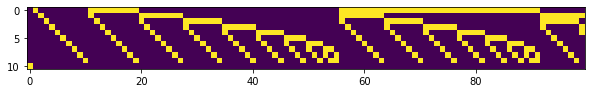

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(count_table[:,:100])

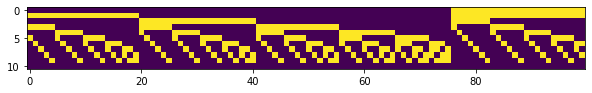

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(count_table[:,100:200])

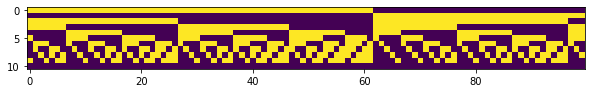

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(count_table[:,450:550])

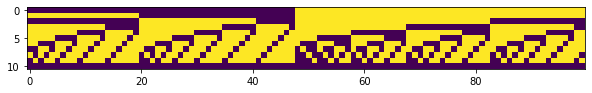

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(count_table[:,800:900])

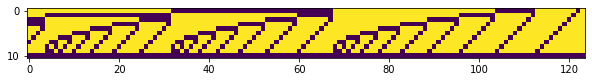

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(count_table[:,900:])

In [17]:
np.sum(count_table, axis=1) / np.sum(np.sum(count_table, axis=1))

array([0.09998047, 0.09998047, 0.09998047, 0.09998047, 0.09998047,
       0.09998047, 0.09998047, 0.09998047, 0.09998047, 0.09998047,
       0.00019527])

In [27]:
u, s , vh = np.linalg.svd(count_table)

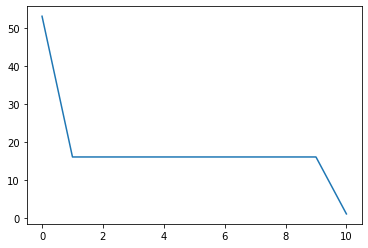

In [28]:
plt.plot(s)

In [34]:
from functools import reduce
import operator as op

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom

In [39]:
K = 10
tot = 0
for i in range(0, K+1):
    i_count = ncr(K,i)
    print(i_count)
    tot += i_count

print(tot)

1
10
45
120
210
252
210
120
45
10
1
1024
